In [2]:
import numpy as np
import time
from matplotlib import pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers

dlist = []
y = []
count = 0
with open('ppdata.csv', 'r', encoding='utf-8') as r:
    count = 0
    for l in r:
        if count > 0:
            #print(type(l))
            l = l.split(',')
            #print(l)
            val = l[0]
            wds = l[1]
            wrds = wds.split(' ')
            #f = [val, wrds]
            dlist.append(wrds)
            y.append([np.asarray(int(val), dtype=np.int32)])
            count += 1
        else:
            count += 1
        #if count > 10:
            #break
            
y = np.array(y)

max_words = 12000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(dlist)
sequences = tokenizer.texts_to_sequences(dlist)
x = pad_sequences(sequences, maxlen=max_len)
x = x.astype(np.float32)

In [3]:
def sigmoid(x):
    """ Sigmoid activation function for an array of neuron outputs.
    Args:
      x: Array/single element of neuron outputs before activation 
    Returns: 
      An array the same length as x with the sigmoid activation applied. 
    """
    return 1/(1+np.exp(-x))


def dsigmoid(y):
    """ Derivative of the sigmoid activation function with respect to the input x of the activation.
      Args: 
        y: Array/single element of neuron outputs after activation 
      Returns: 
        An array the same length as y representing the derivative with respect to x
    """
    return y*(1-y)


def mse(y, pred):
    """Mean squared error function comparing real target values with predictions.
    Args:
      y: List containing real target values 
      pred: List containing predicted target values (must have the same shape as y)
    Returns:
      Mean squared error between the two arrays
    """
    return np.mean(np.square(y - pred))

In [4]:
shuffle_ind = np.random.permutation(len(x))  # shuffle data for training
x = np.array(x[shuffle_ind])


x /= np.max(x)  # linearly scaling the inputs to a range between 0 and 1

train_fraction = 0.75
train_idx = int(len(x)*train_fraction)

x_train = x[:train_idx]
y_train = y[:train_idx]

x_val = x[train_idx:]
y_val = y[train_idx:]

Validation loss: 0.2674574261833931
Validation accuracy: 0.5023035041183862


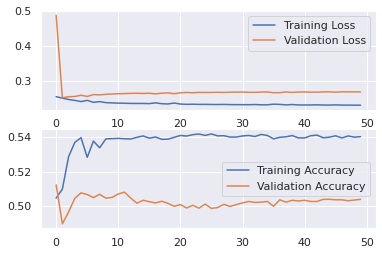

processing time in seconds: 225


In [8]:
start = time.time()

# Training a double layer neural network.
w1 = 2*np.random.random((np.array(x).shape[1], 5)) - 1
w2 = 2*np.random.random((5, 1)) - 1

lr = 0.05 #higer learning rates appear to lead to overfitting
history = {"loss": [], "val_loss": [], "acc": [],
           "val_acc": []}  # Metrics to track while training
epochs = 5000

for iter in range(epochs):
    # forward propagation
    l0 = x_train  # layer 0 output
    l1 = sigmoid(np.matmul(l0, w1))  # layer 1 output
    l2 = sigmoid(np.matmul(l1, w2))  # layer 2 output

    l2_error = l2 - y_train  # Output layer error, (dE/do)
    l2_gradient = dsigmoid(l2)  # (do/dnetx)
    l2_delta = np.multiply(l2_error, l2_gradient) # (dE/do * do/dnetx = dE/dnetx)
    l2_weight_delta = np.matmul(l1.T, l2_delta) # (dnetx/dwij * dE/dnetx = dE/dwij)
    
    l1_error = np.matmul(l2_delta, w2.T)
    l1_gradient = dsigmoid(l1)  # (do/dnetx)
    l1_delta = np.multiply(l1_error, l1_gradient) # (dE/do * do/dnetx = dE/dnetx)
    l1_weight_delta = np.matmul(l0.T, l1_delta) # (dnetx/dwij * dE/dnetx = dE/dwij)

    # update weights with a scaling factor of learning rate
    w2 -= l2_weight_delta * lr
    w1 -= l1_weight_delta * lr

    if iter % 100 == 0:
        # Recording metrics
        train_loss = mse(y_train, l2)
        train_acc = np.sum(y_train == np.around(l2))/len(x_train)
        history["loss"].append(train_loss)
        history["acc"].append(train_acc)

        l1 = sigmoid(np.matmul(x_val, w1))  # layer 1 output
        val_pred = sigmoid(np.matmul(l1, w2))  # layer 2 output
        val_loss = mse(y_val, val_pred)
        val_acc = np.sum(y_val == np.around(val_pred))/len(x_val)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # print('Epoch: {}, Training Loss: {}, Validation Acc: {}'.format(
        #     iter, train_loss, val_acc))

l1 = sigmoid(np.matmul(x_val, w1))  # layer 1 output
val_pred = sigmoid(np.matmul(l1, w2))  # layer 2 output
print("Validation loss: {}".format(mse(y_val, val_pred)))
print("Validation accuracy: {}".format(
    np.sum(y_val == np.around(val_pred))/len(x_val)))

# Plotting
sns.set()
fig = plt.figure()
plt.subplot(2, 1, 1)
plt.plot(history['loss'], label="Training Loss")
plt.plot(history['val_loss'], label="Validation Loss")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(history['acc'], label="Training Accuracy")
plt.plot(history['val_acc'], label="Validation Accuracy")
plt.legend()

plt.show()

end = time.time()
print('processing time in seconds:', int(end-start))